<a href="https://colab.research.google.com/github/ARPAN0109/ARPAN0109/blob/main/West%20Bengal%20Crime%20Data%20Analysis%20and%20Prediction_Conv_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: Import Required Libraries
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import ConvLSTM2D, Dropout, Dense, Flatten, Input
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from google.colab import files
from tensorflow.keras.losses import MeanSquaredError
from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display
import folium
from folium.plugins import HeatMap

In [ ]:
# Cell 2: Upload CSV File and Load Dataset
uploaded = files.upload()

for filename in uploaded.keys():
    data_path = filename

# Load Dataset and Initial Preprocessing
df = pd.read_csv(data_path)

# Check the actual column names
print("Dataset Columns:")
for col in df.columns:
    print(f"'{col}'")

# Fixing Column Names if Needed
df.columns = df.columns.str.strip()

# Load district coordinates
coord_df = pd.read_csv('west_bengal_crime_data.csv')
district_coords = dict(zip(coord_df['District'], zip(coord_df['Latitude'], coord_df['Longitude'])))

Saving west_bengal_crime_data.csv to west_bengal_crime_data.csv
Dataset Columns:
'States/uts'
'District'
'Headquarters'
'Latitude'
'Longitude'
'Year'
'Murder'
'Attempt to commit murder'
'Rape'
'Attempt to commit rape'
'Kidnapping & abduction_total'
'Dacoity'
'Robbery'
'Criminal trespass/burglary'
'Theft'
'Auto theft'
'Other thefts'
'Riots'
'Criminal breach of trust'
'Cheating'
'Forgery'
'Counterfeiting'
'Arson'
'Grievous hurt'
'Dowry deaths'
'Assault on women with intent to outrage her modesty'
'Sexual harassment'
'Insult to the modesty of women'
'Cruelty by husband or his relatives'
'Causing death by negligence'
'Deaths due to negligent driving/act'
'Offences against state'
'Offences promoting enmity between different groups'
'Extortion'
'Incidence of rash driving'
'Humantrafficking'


In [ ]:
# cell 3
unique_counts = df.nunique()

unique_counts

,0
States/uts,1
District,25
Headquarters,24
Latitude,23
Longitude,24
Year,20
Murder,162
Attempt to commit murder,230
Rape,161
Attempt to commit rape,88


In [ ]:
# cell 4
# Define your required five crime types
crime_types = ['Theft', 'Riots', 'Cheating', 'Cruelty by husband or his relatives', 'Grievous hurt']

# Drop rows where District or Year is missing
df_cleaned = df.dropna(subset=['District', 'Year'])

# Calculate total sum for each of the selected five crime types
columns_totals = df_cleaned[crime_types].sum()

# Display the totals
print(columns_totals)

# If you want to sort them in descending order
print(columns_totals.sort_values(ascending=False))


Theft                                  305871.0
Riots                                   72465.0
Cheating                                85155.0
Cruelty by husband or his relatives    279331.0
Grievous hurt                          277198.0
dtype: float64
Theft                                  305871.0
Cruelty by husband or his relatives    279331.0
Grievous hurt                          277198.0
Cheating                                85155.0
Riots                                   72465.0
dtype: float64


In [ ]:
#cell 5
# Select only the five crime types to predict
crime_types = ['Theft', 'Riots', 'Cheating', 'Cruelty by husband or his relatives', 'Grievous hurt']

# Drop rows where District or Year is missing
df_cleaned = df.dropna(subset=['District', 'Year'])

# Group by Year and sum the selected crime types
yearly_totals = df_cleaned.groupby('Year')[crime_types].sum().reset_index()

# Display the year-wise total crime counts
print(yearly_totals)


    Year    Theft   Riots  Cheating  Cruelty by husband or his relatives  \
0   2001  13207.0  3050.0    1209.0                               3857.0   
1   2002  11674.0  2437.0    1308.0                               4068.0   
2   2003  11917.0  2571.0    1522.0                               4947.0   
3   2004  13715.0  2667.0    1665.0                               6333.0   
4   2005  11448.0  2617.0    1726.0                               6936.0   
5   2006  11511.0  2374.0    1919.0                               7321.0   
6   2007  12998.0  3712.0    2395.0                               9900.0   
7   2008  16468.0  5402.0    2925.0                              13662.0   
8   2009  16406.0  6678.0    3270.0                              16103.0   
9   2010  18328.0  6790.0    3234.0                              17794.0   
10  2011  20226.0  6000.0    4152.0                              19769.0   
11  2012  21931.0  6593.0    5271.0                              18196.0   
12  2013  21

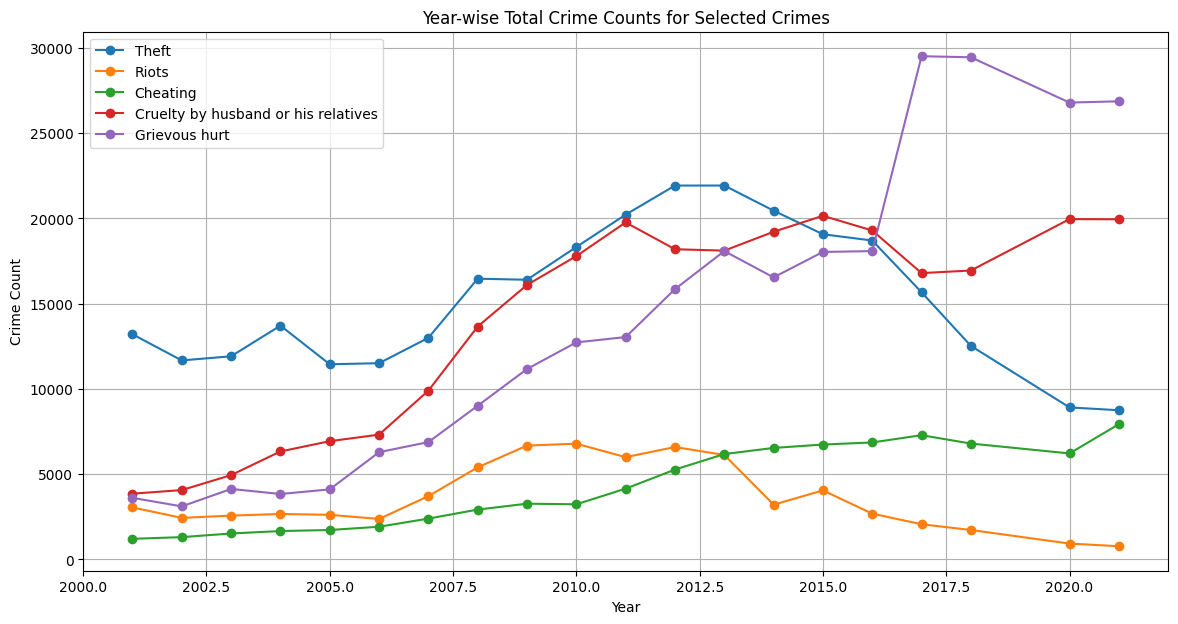

In [ ]:
#cell 6
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
for crime in crime_types:
    plt.plot(yearly_totals['Year'], yearly_totals[crime], marker='o', label=crime)

plt.xlabel('Year')
plt.ylabel('Crime Count')
plt.title('Year-wise Total Crime Counts for Selected Crimes')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# Cell 7: Define Required Crime Types
crime_types = ['Theft', 'Riots', 'Cheating', 'Cruelty by husband or his relatives', 'Grievous hurt']

# Check if all required crime types exist in the dataset
for crime in crime_types:
    if crime not in df.columns:
        raise ValueError(f"'{crime}' not found in dataset columns.")

In [ ]:
# Cell 8: Aggregate Data for West Bengal
# Ensure this cell is run before Cell 9
agg_df = df.groupby('Year')[crime_types].sum().reset_index()

In [ ]:
# Cell 9: Scaling the Data and Save Scaler Permanently
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(agg_df[crime_types])
joblib.dump(scaler, 'wb_crime_scaler.save')

# Save the crime types for later
joblib.dump(crime_types, 'crime_types.save')

['crime_types.save']

In [ ]:
# Cell 10: Prepare Data for ConvLSTM
window_size = 3
X, y = [], []
for i in range(len(data_scaled) - window_size):
    X.append(data_scaled[i:i + window_size])
    y.append(data_scaled[i + window_size])

X, y = np.array(X), np.array(y)

# Reshape to ConvLSTM expected input: (samples, timesteps, rows, cols, channels)
X = X.reshape((X.shape[0], window_size, 1, 1, len(crime_types)))
y = y.reshape((y.shape[0], len(crime_types)))


Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - loss: 0.6221 - mae: 0.6221 - val_loss: 0.1981 - val_mae: 0.1981
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5335 - mae: 0.5335 - val_loss: 0.1938 - val_mae: 0.1938
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.6023 - mae: 0.6023 - val_loss: 0.1885 - val_mae: 0.1885
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5351 - mae: 0.5351 - val_loss: 0.1799 - val_mae: 0.1799
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3897 - mae: 0.3897 - val_loss: 0.1819 - val_mae: 0.1819
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4431 - mae: 0.4431 - val_loss: 0.2745 - val_mae: 0.2745
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2498 - mae: 0.2498 - val_loss: 0.4809 - val_mae: 0.4809
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1962 - mae: 0.1962 - val_loss: 0.4989 - val_mae: 0.4989
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

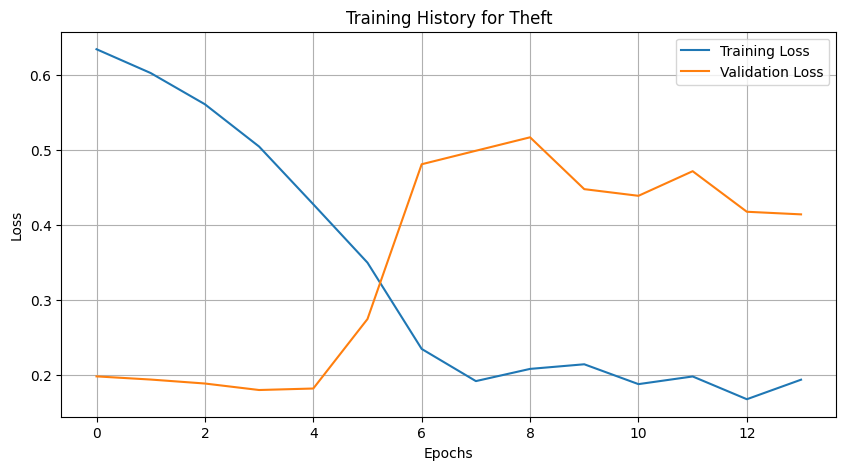

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.6349 - mae: 0.6349 - val_loss: 0.0851 - val_mae: 0.0851
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.5464 - mae: 0.5464 - val_loss: 0.0819 - val_mae: 0.0819
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4138 - mae: 0.4138 - val_loss: 0.0779 - val_mae: 0.0779
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.4994 - mae: 0.4994 - val_loss: 0.0884 - val_mae: 0.0884
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.3575 - mae: 0.3575 - val_loss: 0.2128 - val_mae: 0.2128
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1800 - mae: 0.1800 - val_loss: 0.3187 - val_mae: 0.3187
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2629 - mae: 0.2629 - val_loss: 0.3894 - val_mae: 0.3894
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2232 - mae: 0.2232 - val_loss: 0.4010 - val_mae: 0.4010
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

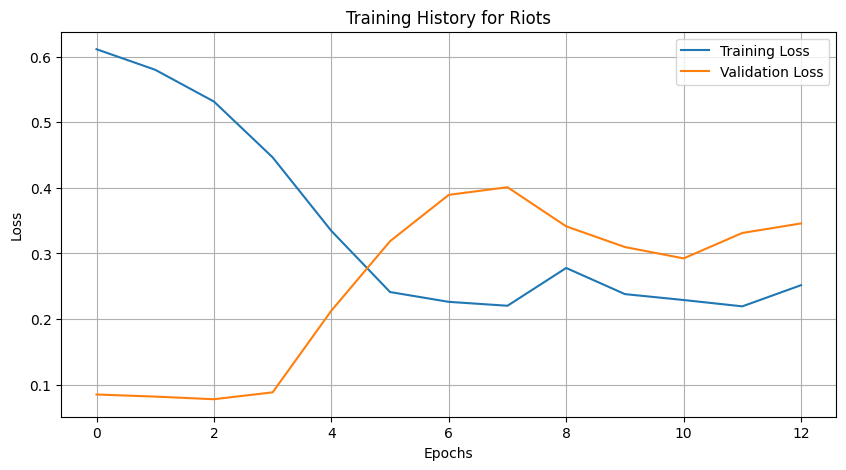

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.4584 - mae: 0.4584 - val_loss: 0.8234 - val_mae: 0.8234
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.4755 - mae: 0.4755 - val_loss: 0.7722 - val_mae: 0.7722
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4400 - mae: 0.4400 - val_loss: 0.7008 - val_mae: 0.7008
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4169 - mae: 0.4169 - val_loss: 0.6130 - val_mae: 0.6130
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.3233 - mae: 0.3233 - val_loss: 0.5101 - val_mae: 0.5101
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.2579 - mae: 0.2579 - val_loss: 0.3519 - val_mae: 0.3519
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.1768 - mae: 0.1768 - val_loss: 0.2246 - val_mae: 0.2246
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.1566 - mae: 0.1566 - val_loss: 0.0893 - val_mae: 0.0893
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - lo

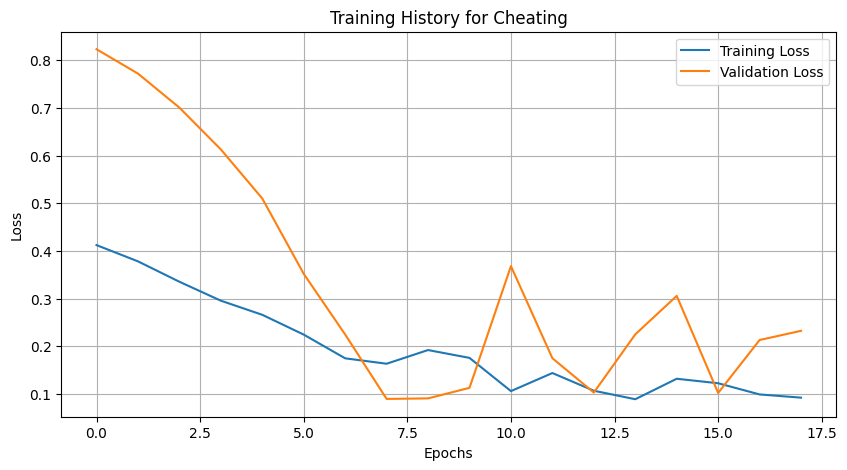

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 0.6932 - mae: 0.6932 - val_loss: 0.8421 - val_mae: 0.8421
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6120 - mae: 0.6120 - val_loss: 0.7814 - val_mae: 0.7814
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5145 - mae: 0.5145 - val_loss: 0.6866 - val_mae: 0.6866
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.5152 - mae: 0.5152 - val_loss: 0.5223 - val_mae: 0.5223
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.4032 - mae: 0.4032 - val_loss: 0.2473 - val_mae: 0.2473
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2467 - mae: 0.2467 - val_loss: 0.1466 - val_mae: 0.1466
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1665 - mae: 0.1665 - val_loss: 0.1723 - val_mae: 0.1723
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1757 - mae: 0.1757 - val_loss: 0.1725 - val_mae: 0.1725
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - lo

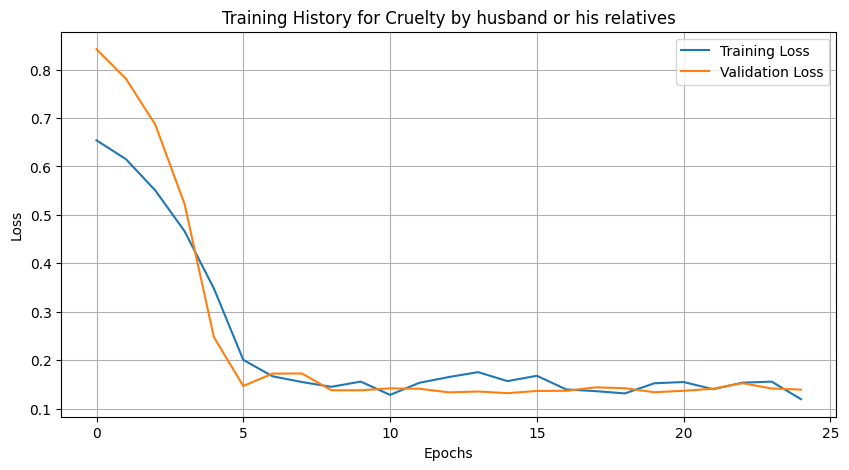

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.3586 - mae: 0.3586 - val_loss: 0.9047 - val_mae: 0.9047
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2829 - mae: 0.2829 - val_loss: 0.8535 - val_mae: 0.8535
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2754 - mae: 0.2754 - val_loss: 0.7891 - val_mae: 0.7891
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1804 - mae: 0.1804 - val_loss: 0.7099 - val_mae: 0.7099
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2170 - mae: 0.2170 - val_loss: 0.5829 - val_mae: 0.5829
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1475 - mae: 0.1475 - val_loss: 0.4821 - val_mae: 0.4821
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1295 - mae: 0.1295 - val_loss: 0.3044 - val_mae: 0.3044
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0757 - mae: 0.0757 - val_loss: 0.2433 - val_mae: 0.2433
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

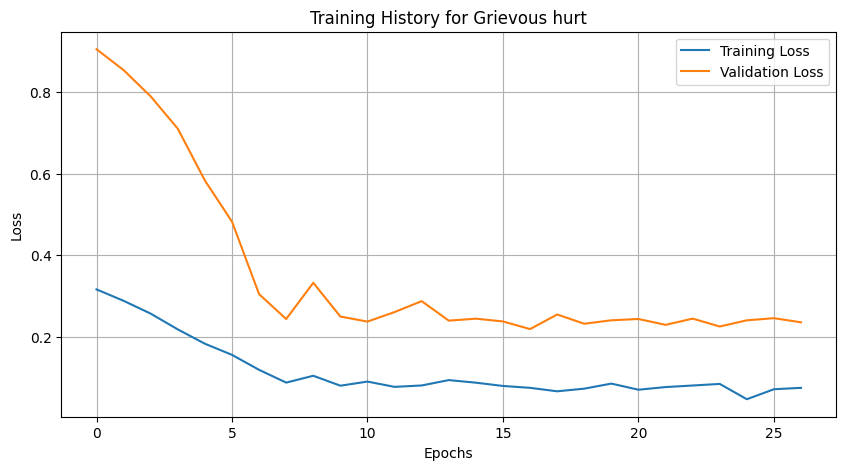

In [ ]:
# Cell 11: Train ConvLSTM Model for Each Crime Type with Improved Accuracy
from tensorflow.keras.optimizers import Adam

window_size = 3
epochs = 100  # Increased epochs for better convergence
base_dir = "zsaved_models_wb"
os.makedirs(base_dir, exist_ok=True)

for crime_index, crime in enumerate(crime_types):
    X_crime = X[..., crime_index].reshape((X.shape[0], window_size, 1, 1, 1))
    y_crime = y[:, crime_index].reshape(-1, 1)

    model = Sequential([
        Input(shape=(window_size, 1, 1, 1)),
        ConvLSTM2D(128, (1, 1), activation='relu', return_sequences=True),  # Added stacked layer
        Dropout(0.3),
        ConvLSTM2D(64, (1, 1), activation='relu'),  # Added more depth
        Dropout(0.3),
        Flatten(),
        Dense(1)
    ])

    optimizer = Adam(learning_rate=0.0005)  # Lower learning rate
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])  # Changed loss to MAE

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(
        X_crime, y_crime,
        epochs=epochs,
        batch_size=1,
        verbose=1,
        validation_split=0.2,
        callbacks=[early_stop]
    )

    model.save(os.path.join(base_dir, f'convlstm_wb_{crime}.keras'))

    # Optional: Plot training history to verify improvement
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training History for {crime}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
import os
import zipfile
from google.colab import files
from tensorflow.keras.models import load_model # Import load_model

# Create a directory to store models temporarily for zipping
os.makedirs("saved_models_zip", exist_ok=True)

# Directory where models were originally saved
source_model_dir = "zsaved_models_wb"

# Save all models to the zip directory
# Iterate through crime types to load and then save each model
for crime in crime_types:
    original_model_path = os.path.join(source_model_dir, f'convlstm_wb_{crime}.keras')
    zip_model_path = f'saved_models_zip/convlstm_wb_{crime}.keras'

    # Load the model from the training directory
    try:
        model = load_model(original_model_path)
        # Save the loaded model to the temporary zip directory
        model.save(zip_model_path)
    except Exception as e:
        print(f"Could not load or save model for {crime}: {e}")
        # Handle cases where a model might not have been saved in the previous step
        continue # Skip to the next crime type


# Save scaler and crime_types to the zip directory
try:
    joblib.dump(scaler, 'saved_models_zip/wb_crime_scaler.save')
except NameError:
    print("Error: 'scaler' not defined. Please run the data scaling cell (Cell 9).")
    # Decide how to proceed if scaler is missing - maybe skip zipping or handle error
except Exception as e:
    print(f"An error occurred saving scaler: {e}")


try:
    joblib.dump(crime_types, 'saved_models_zip/crime_types.save')
except NameError:
     print("Error: 'crime_types' not defined. Please run the relevant cells to define crime_types.")
except Exception as e:
     print(f"An error occurred saving crime_types: {e}")


# Create a zip file
zip_filename = 'west_bengal_models_bundle.zip'
# Check if the temporary directory has contents before zipping
if os.listdir("saved_models_zip"):
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for root, dirs, files_in_dir in os.walk("saved_models_zip"):
            for file in files_in_dir:
                full_path = os.path.join(root, file)
                arcname = os.path.relpath(full_path, "saved_models_zip")
                zipf.write(full_path, arcname=arcname)

    # Download the zip
    files.download(zip_filename)
else:
    print("No files found in 'saved_models_zip' to create the zip file.")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Cell 12: Load Model and Make Predictions with Widgets
import ipywidgets as widgets # Added import here for robustness if cells are run out of order
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import numpy as np
import folium
from folium.plugins import HeatMap
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import load_model
import pandas as pd # Assuming agg_df and df are needed and were created in previous cells
from sklearn.preprocessing import MinMaxScaler # Assuming scaler is needed

# Assuming agg_df and crime_types were defined in previous cells
# If not, you might need to re-run the preceding cells.
# For demonstration, we'll assume they are available or will be after running previous cells.
# Example placeholders if running this cell alone for testing (remove in final code):
# crime_types = ['Theft', 'Riots', 'Cheating', 'Cruelty by husband or his relatives', 'Grievous hurt']
# agg_df = pd.DataFrame({'Year': range(2000, 2020), 'Theft': np.random.rand(20)*1000, 'Riots': np.random.rand(20)*500, 'Cheating': np.random.rand(20)*700, 'Cruelty by husband or his relatives': np.random.rand(20)*300, 'Grievous hurt': np.random.rand(20)*200})
# window_size = 3

# Load crime types from the saved file before creating widgets
try:
    crime_types = joblib.load('crime_types.save')
except FileNotFoundError:
    print("Error: 'crime_types.save' not found. Please run the data scaling cell (Cell 9) first.")
    # Define a default or exit gracefully if the file is missing
    crime_types = [] # Define an empty list to prevent further errors, though functionality will be limited
except Exception as e:
    print(f"An error occurred loading crime_types: {e}")
    crime_types = []


crime_dropdown = widgets.Dropdown(
    options=crime_types,
    description='Crime:'
)

year_slider = widgets.IntSlider(
    value=1,
    min=1,
    max=10,
    step=1,
    description='Years:'
)

ui = widgets.VBox([crime_dropdown, year_slider])

def forecast_crime(crime, forecast_steps):
    # Ensure necessary variables are available
    # We already loaded crime_types globally, so no need to re-load here
    global agg_df, window_size # Declare global if they might not be in scope

    model_path = f'zsaved_models_wb/convlstm_wb_{crime}.keras'
    # Ensure scaler and crime_types save files exist from previous cells
    try:
        scaler = joblib.load('wb_crime_scaler.save')
        # crime_types_loaded = joblib.load('crime_types.save') # No need to load again
        # Ensure crime_types used in this function are consistent
        # if crime_types != crime_types_loaded: # Check against the globally loaded one if needed
        #      print("Warning: crime_types mismatch between loaded and current. Using loaded ones.")
        #      crime_types = crime_types_loaded

    except FileNotFoundError:
        print("Error: Scaler save file not found. Please run the data scaling cell (Cell 9).")
        return
    except Exception as e:
        print(f"An error occurred loading scaler: {e}")
        return


    try:
        model = load_model(model_path)
    except Exception as e:
        print(f"Error loading model {model_path}: {e}. Please ensure models were trained and saved (Cell 11).")
        return

    # Ensure agg_df is available
    if 'agg_df' not in globals() or agg_df is None:
        print("Error: 'agg_df' not found. Please run the data aggregation cell (Cell 8).")
        return

    selected_data = agg_df[['Year', crime]].sort_values('Year')
    selected_data[crime] = selected_data[crime].ffill().bfill().fillna(selected_data[crime].median())
    values = selected_data[crime].values.reshape(-1, 1)

    # Ensure window_size is available
    if 'window_size' not in globals() or window_size is None:
        print("Error: 'window_size' not found. Please run the data preparation cell (Cell 10).")
        return

    # Ensure there's enough data for windowing
    if len(values) < window_size:
        print(f"Error: Not enough data points ({len(values)}) for window size ({window_size}).")
        return

    # Use the globally available crime_types for scaling the full data
    scaled_values = scaler.transform(agg_df[crime_types])
    # Find the index of the current crime type safely
    try:
        # Use the globally available crime_types for indexing
        crime_index_in_all = crime_types.index(crime)
    except ValueError:
        print(f"Error: '{crime}' not found in the list of crime types used for scaling.")
        return

    values_scaled = scaled_values[:, crime_index_in_all].reshape(-1, 1)

    X_test = []
    for i in range(len(values_scaled) - window_size):
        X_test.append(values_scaled[i:i + window_size])

    if not X_test:
        print(f"Error: Cannot create X_test with window_size {window_size}. Data length: {len(values_scaled)}")
        return

    X_test = np.array(X_test).reshape((len(X_test), window_size, 1, 1, 1))

    predictions = model.predict(X_test, verbose=0)
    # Use the globally available crime_types for dummy array size
    dummy_scaled = np.zeros((len(predictions), len(crime_types)))
    dummy_scaled[:, crime_index_in_all] = predictions.flatten()
    # Use the globally available crime_types for inverse transform
    predictions_inverse = scaler.inverse_transform(dummy_scaled)[:, crime_index_in_all]

    # Ensure actual_values and predictions_inverse have compatible shapes for metrics
    actual_values = values[window_size:].flatten()
    predicted_values = predictions_inverse.flatten()

    if len(actual_values) != len(predicted_values):
         print(f"Warning: Length mismatch between actual ({len(actual_values)}) and predicted ({len(predicted_values)}) values for metrics.")
         # Adjust lengths if necessary for calculation, or skip metrics calculation if mismatch is severe
         min_len = min(len(actual_values), len(predicted_values))
         actual_values = actual_values[:min_len]
         predicted_values = predicted_values[:min_len]
         if min_len == 0:
             print("Cannot calculate metrics due to insufficient data.")
             mse = mae = percentage_error = np.nan # Or some other indicator
         else:
             mse = mean_squared_error(actual_values, predicted_values)
             mae = mean_absolute_error(actual_values, predicted_values)
             non_zero_indices = actual_values != 0
             if len(actual_values[non_zero_indices]) > 0:
                 percentage_error = np.mean(np.abs((actual_values[non_zero_indices] - predicted_values[non_zero_indices]) / actual_values[non_zero_indices])) * 100
             else:
                 percentage_error = 0
    else:
        mse = mean_squared_error(actual_values, predicted_values)
        mae = mean_absolute_error(actual_values, predicted_values)
        non_zero_indices = actual_values != 0
        if len(actual_values[non_zero_indices]) > 0:
            percentage_error = np.mean(np.abs((actual_values[non_zero_indices] - predicted_values[non_zero_indices]) / actual_values[non_zero_indices])) * 100
        else:
            percentage_error = 0


    # Prepare input for forecasting
    if len(values_scaled) < window_size:
        print(f"Error: Not enough data points ({len(values_scaled)}) to create initial input sequence for forecasting with window size {window_size}.")
        return

    input_seq = values_scaled[-window_size:].reshape((1, window_size, 1, 1, 1))
    forecast = []
    for _ in range(forecast_steps):
        pred = model.predict(input_seq, verbose=0)
        forecast.append(pred[0, 0])
        next_seq = np.append(input_seq[:, 1:], pred.reshape((1, 1, 1, 1, 1)), axis=1)
        input_seq = next_seq

    # Use the globally available crime_types for dummy array size
    dummy_forecast = np.zeros((len(forecast), len(crime_types)))
    dummy_forecast[:, crime_index_in_all] = forecast
    # Use the globally available crime_types for inverse transform
    forecast_inverse = scaler.inverse_transform(dummy_forecast)[:, crime_index_in_all]

    years = sorted(selected_data['Year'].unique())
    # Ensure there are enough years to plot predicted data
    if len(years) < window_size:
         predicted_years = []
    else:
         predicted_years = years[window_size:]

    forecast_years = [years[-1] + i for i in range(1, forecast_steps + 1)]

    # Plot forecast vs actual vs predicted
    plt.figure(figsize=(14, 7))
    plt.plot(years, values.flatten(), label='Actual Data', marker='o')
    # Only plot predicted data if it exists and matches length
    if len(predicted_years) == len(predictions_inverse):
        plt.plot(predicted_years, predictions_inverse.flatten(), label='Predicted Data', marker='x', linestyle='--')
    else:
        print(f"Warning: Skipping plotting predicted data due to length mismatch. Predicted years: {len(predicted_years)}, Predicted values: {len(predictions_inverse)}")

    plt.plot(forecast_years, forecast_inverse.flatten(), label='Forecast', marker='s', linestyle='-.', color='red')
    plt.xlabel('Year')
    plt.ylabel('Crime Count')
    plt.title(f'{crime} Forecast for West Bengal\nMSE: {mse:.2f}, MAE: {mae:.2f}, Percentage Error: {percentage_error:.2f}%')
    # Adjust xticks to cover the range of years plotted
    all_years_for_xticks = sorted(list(years) + list(forecast_years))
    if all_years_for_xticks:
        plt.xticks(np.arange(min(all_years_for_xticks), max(all_years_for_xticks) + 1, step=1), rotation=45)
    else:
         print("Warning: No years to display on x-axis.")

    plt.legend()
    plt.grid()
    plt.show()

    print(f"\nForecasted Crime Counts:")
    for year, value in zip(forecast_years, forecast_inverse.flatten()):
        print(f"{year}: {value:.2f}")

    print(f"\nResidual Metrics:\nMean Squared Residual (MSE): {mse:.2f}\nMean Absolute Residual (MAE): {mae:.2f}\nResidual: {percentage_error:.2f}%")

    # Load base map data
    try:
        district_coords_df = pd.read_csv('west_bengal_crime_data.csv')
        district_coords = dict(zip(district_coords_df['District'], zip(district_coords_df['Latitude'], district_coords_df['Longitude'])))
    except FileNotFoundError:
        print("Error: 'west_bengal_crime_data.csv' not found. Cannot generate maps.")
        return
    except Exception as e:
        print(f"An error occurred loading district coordinates: {e}")
        return

    # Ensure df is available for base data
    # df is defined in Cell 2, so it should be available if previous cells ran
    if 'df' not in globals() or df is None:
        print("Error: Original 'df' not found. Please run the data loading cell (Cell 2).")
        return

    # Group base data
    # Ensure the crime column exists in df before grouping
    if crime not in df.columns:
        print(f"Error: Crime type '{crime}' not found in the original 'df' for map generation.")
        return

    pivot_df = df.groupby(['Year', 'District'])[crime].sum().reset_index()

    # Use latest year available in data (not hardcoded)
    if pivot_df.empty:
        print("Error: Pivot table is empty. Cannot generate maps.")
        return
    last_actual_year = pivot_df['Year'].max()
    base_year_df = pivot_df[pivot_df['Year'] == last_actual_year]

    if base_year_df.empty:
         print(f"Warning: No data found for the last actual year {last_actual_year}. Cannot generate maps.")
         return


    # Generate maps year-wise
    for i, year in enumerate(forecast_years):
        # Estimate district-wise crime for forecast year
        total_prev = base_year_df[crime].sum()
        if total_prev == 0:
             print(f"Warning: Total crime for '{crime}' in year {last_actual_year} is zero. Cannot estimate district-wise forecast for year {year}.")
             continue # Skip map generation for this year if base total is zero

        year_df = base_year_df.copy()
        year_df['forecasted_crime'] = (year_df[crime] / total_prev) * forecast_inverse[i]
        year_df['Year'] = year

        # Grid Map
        pivot_table = year_df.pivot(index='District', columns='Year', values='forecasted_crime')
        pivot_table = pivot_table[[year]].fillna(0)

        plt.figure(figsize=(14, 8))
        # Handle potential NaN or Inf values before plotting heatmap
        sns.heatmap(pivot_table.replace([np.inf, -np.inf], np.nan).fillna(0), annot=True, fmt='.0f', cmap='YlOrRd')
        plt.title(f'{crime} Grid Map Forecast - Year {year}')
        plt.ylabel('Districts')
        plt.xlabel('Year')
        plt.show()

        # Folium Heatmap
        wb_map = folium.Map(location=[23.5, 87.5], zoom_start=7)
        heat_data = []

        for idx, row in year_df.iterrows():
            district = row['District']
            if district in district_coords:
                lat, lon = district_coords[district]
                # Ensure value is a valid number before using in Folium
                value = row['forecasted_crime']
                if pd.notna(value) and value > 0: # Only add non-negative, non-NaN values
                    folium.CircleMarker(
                        location=[lat, lon],
                        radius=max(value / 1000, 5), # Ensure radius is positive
                        color='crimson',
                        fill=True,
                        fill_color='crimson',
                        popup=f'{district}: {value:.0f}'
                    ).add_to(wb_map)
                    heat_data.append([lat, lon, value]) # Add to heatmap data

        # Only add heatmap layer if there's data
        if heat_data:
             HeatMap(heat_data).add_to(wb_map)
             display(wb_map)
        else:
             print(f"Warning: No valid data points for heatmap for year {year}. Skipping Folium map.")
             display(wb_map) # Display base map even if no heatmap data


interactive_forecast = widgets.interactive(forecast_crime, crime=crime_dropdown, forecast_steps=year_slider)
display(ui, interactive_forecast)

interactive(children=(Dropdown(description='Crime:', options=('Theft', 'Riots', 'Cheating', 'Cruelty by husban…

# New section